In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
#IMPORT NECESSARY PACKAGES
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing

In [39]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [3]:
#Get the data from CHPC
data_orig = retrieve_data_from_folder('Z:\\CO2_Data_Final')

Enter Start Date YYYY-mm-DD:  2019-09-24
Enter End Date YYYY-mm-DD:  2019-09-26


Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26


In [40]:
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 

Concatenating Picarro Data


C:\Users\agmey\Google Drive\Documents\McPherson\CO2_UnionRoof_Meyer\Code\CO2_Eddy\CO2_Processing.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vent_Anem_Temp']['DOW'] = data['Vent_Anem_Temp']['Corrected_DT'].dt.dayofweek


setting night vent data to zero


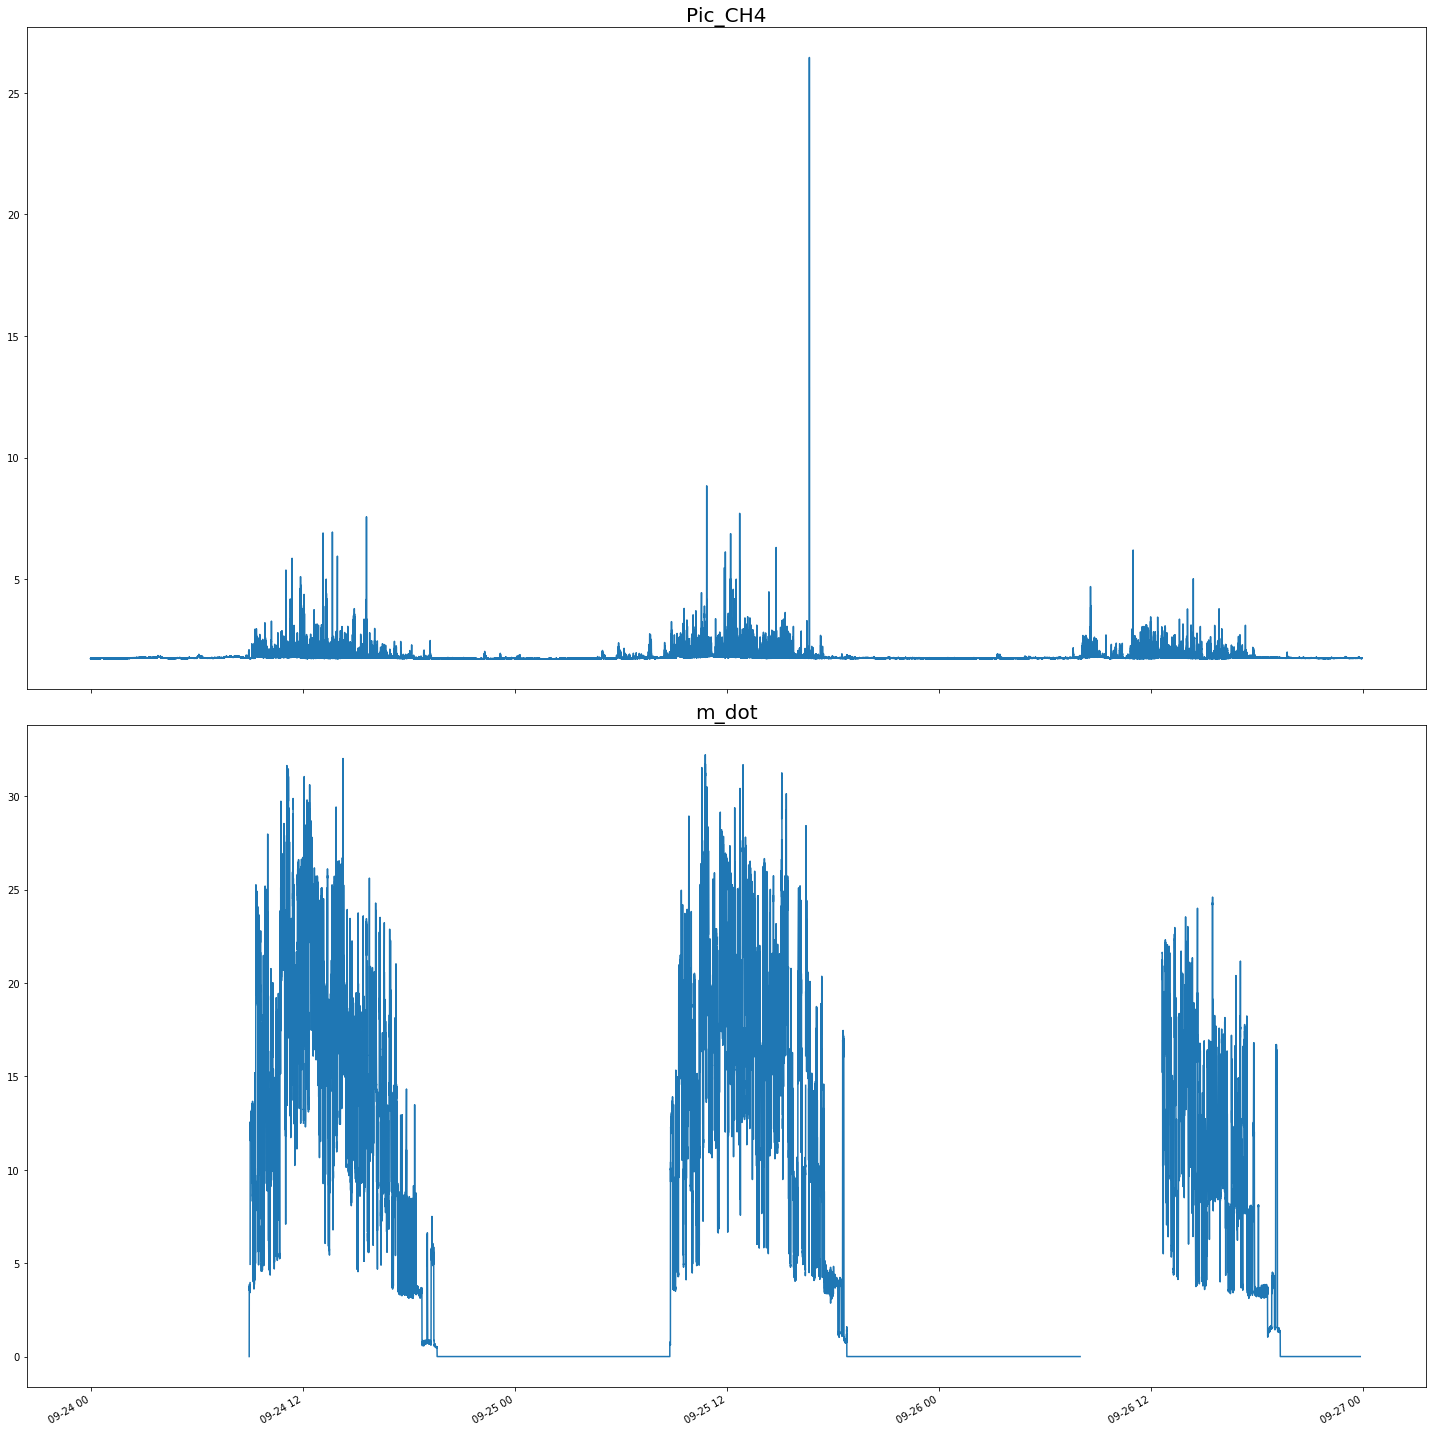

Is this an acceptable range?  y


In [41]:
#Clip the picarro and vent_mass data frames to a specific region of interest
pic,vent = plot_refinement_all([[data['Picarro'],'Corrected_DT','Pic_CH4'],\
                                [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                               'separate')

In [26]:
vent.interpolate(inplace =True)

In [27]:
#Apply a moving average and downsample
#Numbers of seconds
vent.drop('DOW',inplace=True,axis=1)

pic_proc = moving_average(pic,1)
vent_proc = moving_average(vent,1)

pic_proc = dwn_sample(pic_proc,1)
vent_proc = dwn_sample(vent_proc,1)

Applying a central moving average of 1 seconds
Applying a central moving average of 1 seconds
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [57]:
#Concatenate and add wind speed & direction
df = pd.concat([pic_proc,vent_proc],axis=1)
df = wind_add(df,'ANEM_X','ANEM_Y')

#Drop columns
df.drop(['DOW','Pic_Loc','LI_CO2','Rotations','Velocity','Temp_1','Temp_2','Q','Excess'],axis=1,inplace=True)
df.dropna(inplace=True)

Adding Wind Direction as 'wd'


C:\Users\agmey\Anaconda3\envs\CO2_Eddy\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Adding Wind Speed as 'ws'


In [58]:
#Make mass flux the last column
loc = df.columns.get_loc('m_dot')

cols = df.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
df = df[cols]



In [ ]:
df1 = df
df1['wd_ct'] = np.zeros(len(df1))
for i in range(1,len(df1)):
    if (df1['wd'][i] > 240) & (df1['wd'][i] < 300):
        df1['wd_ct'][i] = df1['wd_ct'][i-1]+1
    else:
        continue

df2 = df1.loc[df1['wd_ct']>=0]
df2.drop('wd_ct',axis=1,inplace=True)

In [ ]:
#SET UP TIME LAGGING FUNTION
#Courtesy of Jason Brownlee
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
#We need to delete some of the columns generated by the series_to_supervised function
def delete_unwanted_cols(initial_lagged_df):
    #We want to delete all of the values of LI_CO2 EXCEPT the t=t case (very last one)
    s = "m_dot" 
    drop_cols = [] #initialize columns to be dropped
    for column in initial_lagged_df:
        if s not in column and "(t)" in column:
            drop_cols.append(column)     #Drop all columns except the LI_CO2 column at time t (only want the lagged variables)
        elif s in column and "(t)" not in column:
            drop_cols.append(column)     #Drop all columns with LI_CO2 that arent the last one
    return initial_lagged_df.drop(drop_cols,axis = 1)  

In [ ]:
#TIME LAG
n_seconds = 10 #how many periods to lag
n_features= len(df2.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df2,n_in=0,n_out=n_seconds) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns
#pd.set_option("display.max_columns", 9)
cols = list(time_lagged_reframed.columns)
cols = cols[1:] + [cols[0]]
time_lagged_reframed = time_lagged_reframed[cols]
time_lagged_reframed.head()

In [ ]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
#values  = df.dropna().values
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

In [50]:
#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.75
train_size = int(len(df)*percent_train) 

In [51]:
train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

In [52]:
X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

In [53]:
X_train = X_train.reshape((X_train.shape[0], 1, 9)) 
X_test = X_test.reshape((X_test.shape[0], 1, 9))
#X_train = X_train.reshape((X_train.shape[0], n_seconds-1, n_features)) 
#X_test = X_test.reshape((X_test.shape[0], n_seconds-1, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(449415, 1, 9) (449415,) (149805, 1, 9) (149805,)


In [54]:
model = Sequential()
model.add(LSTM(128,input_shape=(X_train.shape[1:]),activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
model.fit(X_train,y_train,epochs=3,validation_data=(X_test,y_test))

Train on 449415 samples, validate on 149805 samples
Epoch 1/3
449415/449415 [==============================] - 161s 357us/sample - loss: 0.0309 - accuracy: 0.1148 - val_loss: 0.0337 - val_accuracy: 0.0000e+00
Epoch 2/3
449415/449415 [==============================] - 138s 306us/sample - loss: 0.0281 - accuracy: 0.1147 - val_loss: 0.0372 - val_accuracy: 0.0000e+00
Epoch 3/3
449415/449415 [==============================] - 143s 318us/sample - loss: 0.0270 - accuracy: 0.1147 - val_loss: 0.0352 - val_accuracy: 0.0000e+00


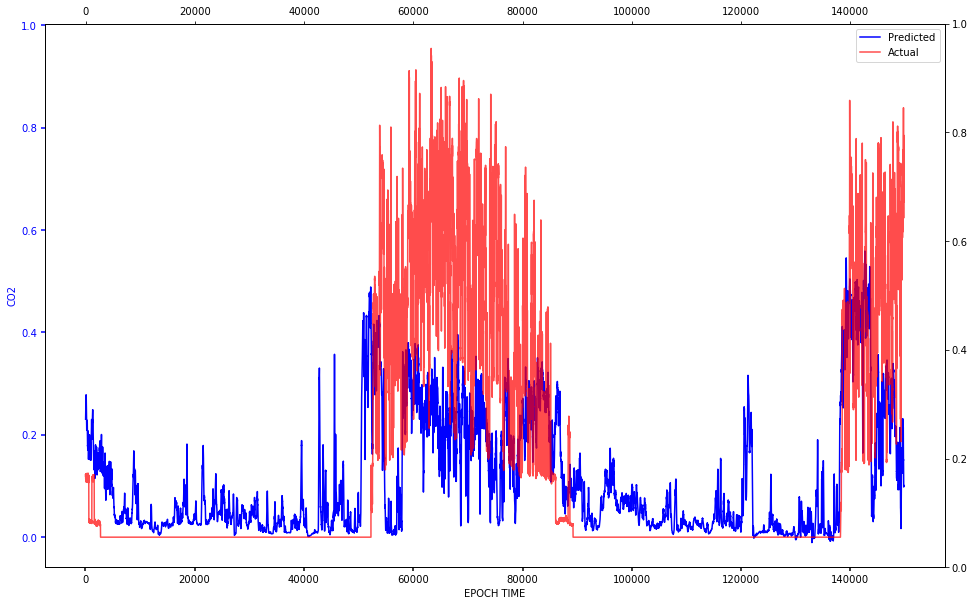

In [56]:
#PLOT PREDICTED VS OBSERVED
yfit = model.predict(X_test)
yfit = pd.DataFrame(yfit)
yfit_roll = yfit.rolling(100,center=True).mean()

fig, host = plt.subplots(figsize = (20,10))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par1 = host.twiny()


p1, = host.plot(yfit_roll, "b-", label="Predicted")
p2, = par1.plot(y_test, "r-", alpha = 0.7,label="Actual")

host.set_xlabel("EPOCH TIME")
host.set_ylabel("CO2")
par1.set_ylabel("CO2")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])

plt.show()